# 分子類似性検索 (Molecular Similarity Search)

## 概要

分子類似性検索は、既知の活性化合物と構造的に類似した新しい化合物を発見するための重要な創薬手法です。本ノートブックでは、様々な類似性指標とフィンガープリント手法を用いて、効率的な分子類似性検索システムを構築します。

## 学習目標

- 分子類似性の概念と創薬における重要性を理解する
- 各種フィンガープリント手法の特徴と使い分けを学ぶ
- Tanimoto係数をはじめとする類似性指標を習得する
- バーチャルスクリーニングの実装と評価方法を学ぶ
- 化学空間の可視化と分析手法を理解する

## 補助資料

**初心者の方へ**: この内容が難しく感じる場合は、以下の補助資料をご参照ください：

- **[分子類似性検索 初心者ガイド](../similarity-search-beginner-guide/)**: 基本概念を日常的な例えで解説
- **[分子類似性検索 用語集](../similarity-search-glossary/)**: 専門用語の分かりやすい説明と参考リンク

これらの資料は、文系出身の方や化学・情報学の予備知識が少ない方でも理解できるよう工夫されています。

## ダウンロード

<a class="link" href="/files/similarity-search_executed.ipynb" download>📓 実行済みノートブックをダウンロード</a>

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs
from rdkit.Chem import Draw
from rdkit.DataStructs import TanimotoSimilarity, DiceSimilarity, TverskySimilarity
from rdkit.ML.Cluster import Butina
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = "Noto Sans CJK JP"
sns.set_style("whitegrid")

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. 分子フィンガープリントの種類と比較

分子フィンガープリントは分子の構造情報をビットベクトルで表現する手法です。用途に応じて適切なフィンガープリントを選択することが重要です。

In [2]:
# 各種フィンガープリントの実装
def generate_fingerprints(mol):
    """分子から各種フィンガープリントを生成"""
    fingerprints = {}
    
    if mol is not None:
        # Morgan フィンガープリント（ECFP4相当）
        fingerprints['Morgan_r2'] = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        fingerprints['Morgan_r3'] = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
        
        # RDKit フィンガープリント
        fingerprints['RDKit'] = Chem.RDKFingerprint(mol, fpSize=1024)
        
        # MACCS キー
        fingerprints['MACCS'] = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        
        # AtomPair フィンガープリント
        fingerprints['AtomPair'] = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=1024)
        
        # Topological Torsion フィンガープリント
        fingerprints['TopologicalTorsion'] = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=1024)
    
    return fingerprints

# テスト用の薬物分子
test_molecules = {
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "イブプロフェン": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "ナプロキセン": "COC1=CC=CC2=C1C=C(C=C2)C(C)C(=O)O",
    "インドメタシン": "CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O",
    "ジクロフェナク": "O=C(O)CC1=CC=CC=C1NC2=C(Cl)C=CC=C2Cl",
    "セレコキシブ": "CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)C(F)(F)F)C(F)(F)F"
}

print("フィンガープリント生成テスト:")
print("=" * 50)

# 各分子のフィンガープリントを生成
fp_data = {}
for name, smiles in test_molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fps = generate_fingerprints(mol)
        fp_data[name] = fps
        print(f"{name}:")
        for fp_type, fp in fps.items():
            print(f"  {fp_type}: {fp.GetNumOnBits()}/{len(fp)} bits on")
        print()

フィンガープリント生成テスト:
アスピリン:
  Morgan_r2: 24/1024 bits on
  Morgan_r3: 31/1024 bits on
  RDKit: 319/1024 bits on
  MACCS: 21/167 bits on
  AtomPair: 68/1024 bits on
  TopologicalTorsion: 17/1024 bits on

イブプロフェン:
  Morgan_r2: 25/1024 bits on
  Morgan_r3: 30/1024 bits on
  RDKit: 214/1024 bits on
  MACCS: 15/167 bits on
  AtomPair: 91/1024 bits on
  TopologicalTorsion: 21/1024 bits on

ナプロキセン:
  Morgan_r2: 34/1024 bits on
  Morgan_r3: 45/1024 bits on
  RDKit: 337/1024 bits on
  MACCS: 22/167 bits on
  AtomPair: 108/1024 bits on
  TopologicalTorsion: 28/1024 bits on

インドメタシン:
  Morgan_r2: 39/1024 bits on
  Morgan_r3: 54/1024 bits on
  RDKit: 775/1024 bits on
  MACCS: 41/167 bits on
  AtomPair: 175/1024 bits on
  TopologicalTorsion: 41/1024 bits on

ジクロフェナク:
  Morgan_r2: 29/1024 bits on
  Morgan_r3: 41/1024 bits on
  RDKit: 392/1024 bits on
  MACCS: 28/167 bits on
  AtomPair: 132/1024 bits on
  TopologicalTorsion: 29/1024 bits on

セレコキシブ:
  Morgan_r2: 39/1024 bits on
  Morgan_r3: 52/1024 bits o

[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:43] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:43] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:43] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use MorganGenerator
[17:00:43] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:43] DEPRECATION WARNING: please use TopologicalTorsionGenerator


## 2. 類似性指標の比較

分子類似性を定量化するための様々な指標があります。最も一般的なTanimoto係数に加えて、Dice係数、Tversky係数などを比較します。

In [3]:
# 類似性指標の計算と比較
def calculate_similarity_metrics(fp1, fp2):
    """2つのフィンガープリント間の類似性指標を計算"""
    metrics = {}
    
    # Tanimoto 係数
    metrics['Tanimoto'] = TanimotoSimilarity(fp1, fp2)
    
    # Dice 係数
    metrics['Dice'] = DiceSimilarity(fp1, fp2)
    
    # Tversky 係数（α=0.8, β=0.2）
    metrics['Tversky_0.8_0.2'] = TverskySimilarity(fp1, fp2, 0.8, 0.2)
    
    # Tversky 係数（α=0.5, β=0.5）- Tanimoto係数と同等
    metrics['Tversky_0.5_0.5'] = TverskySimilarity(fp1, fp2, 0.5, 0.5)
    
    return metrics

# アスピリンを基準分子として類似性を計算
reference_mol = "アスピリン"
reference_fps = fp_data[reference_mol]

print(f"基準分子: {reference_mol}")
print("=" * 60)

similarity_results = []
for mol_name, fps in fp_data.items():
    if mol_name != reference_mol:
        # Morgan フィンガープリント（r=2）で類似性計算
        similarities = calculate_similarity_metrics(
            reference_fps['Morgan_r2'], 
            fps['Morgan_r2']
        )
        
        result = {'分子': mol_name}
        result.update(similarities)
        similarity_results.append(result)
        
        print(f"\n{mol_name}:")
        for metric, value in similarities.items():
            print(f"  {metric:15}: {value:.3f}")

# 類似性結果をDataFrameに変換
df_similarity = pd.DataFrame(similarity_results)

基準分子: アスピリン

イブプロフェン:
  Tanimoto       : 0.195
  Dice           : 0.327
  Tversky_0.8_0.2: 0.331
  Tversky_0.5_0.5: 0.327

ナプロキセン:
  Tanimoto       : 0.261
  Dice           : 0.414
  Tversky_0.8_0.2: 0.462
  Tversky_0.5_0.5: 0.414

インドメタシン:
  Tanimoto       : 0.189
  Dice           : 0.317
  Tversky_0.8_0.2: 0.370
  Tversky_0.5_0.5: 0.317

ジクロフェナク:
  Tanimoto       : 0.205
  Dice           : 0.340
  Tversky_0.8_0.2: 0.360
  Tversky_0.5_0.5: 0.340

セレコキシブ:
  Tanimoto       : 0.105
  Dice           : 0.190
  Tversky_0.8_0.2: 0.222
  Tversky_0.5_0.5: 0.190


## 3. フィンガープリント手法の性能比較

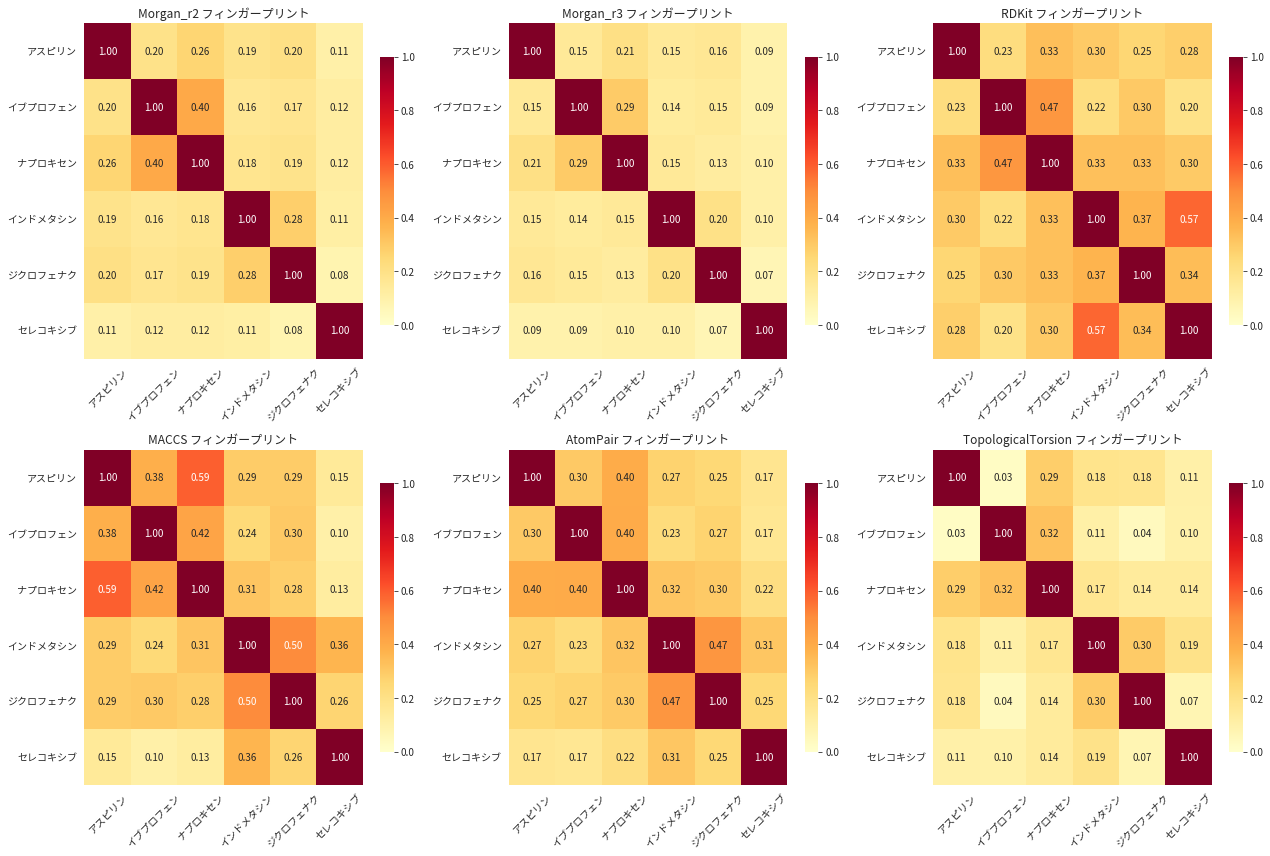

フィンガープリント手法の特徴分析:
Morgan_r2           : 平均類似度 0.186 ± 0.080
Morgan_r3           : 平均類似度 0.146 ± 0.054
RDKit               : 平均類似度 0.322 ± 0.093
MACCS               : 平均類似度 0.308 ± 0.129
AtomPair            : 平均類似度 0.289 ± 0.081
TopologicalTorsion  : 平均類似度 0.157 ± 0.087


In [4]:
# 各フィンガープリント手法での類似性行列を作成
plt.rcParams['font.family'] = "Noto Sans CJK JP"

fingerprint_types = ['Morgan_r2', 'Morgan_r3', 'RDKit', 'MACCS', 'AtomPair', 'TopologicalTorsion']
mol_names = list(fp_data.keys())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, fp_type in enumerate(fingerprint_types):
    # 類似性行列の計算
    n_mols = len(mol_names)
    similarity_matrix = np.zeros((n_mols, n_mols))
    
    for i, mol1 in enumerate(mol_names):
        for j, mol2 in enumerate(mol_names):
            if fp_type in fp_data[mol1] and fp_type in fp_data[mol2]:
                similarity = TanimotoSimilarity(
                    fp_data[mol1][fp_type], 
                    fp_data[mol2][fp_type]
                )
                similarity_matrix[i, j] = similarity
    
    # ヒートマップの作成
    sns.heatmap(similarity_matrix, 
                annot=True, 
                fmt='.2f',
                xticklabels=[name[:8] + '...' if len(name) > 8 else name for name in mol_names],
                yticklabels=[name[:8] + '...' if len(name) > 8 else name for name in mol_names],
                cmap='YlOrRd',
                vmin=0, vmax=1,
                ax=axes[idx],
                cbar_kws={'shrink': 0.8})
    
    axes[idx].set_title(f'{fp_type} フィンガープリント', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# フィンガープリント手法の特徴を分析
print("フィンガープリント手法の特徴分析:")
print("=" * 50)

for fp_type in fingerprint_types:
    similarities = []
    for i, mol1 in enumerate(mol_names):
        for j, mol2 in enumerate(mol_names):
            if i < j and fp_type in fp_data[mol1] and fp_type in fp_data[mol2]:
                sim = TanimotoSimilarity(fp_data[mol1][fp_type], fp_data[mol2][fp_type])
                similarities.append(sim)
    
    if similarities:
        print(f"{fp_type:20}: 平均類似度 {np.mean(similarities):.3f} ± {np.std(similarities):.3f}")

## 4. 化学空間の可視化

分子フィンガープリントを用いて化学空間を可視化し、分子間の関係性を理解します。t-SNEとPCAを用いて次元削減を行います。

分析対象分子数: 16


[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:46] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:46] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:46] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use MorganGenerator
[17:00:46] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:46] DEPRECATION WARNING: please use TopologicalTorsionGenerator


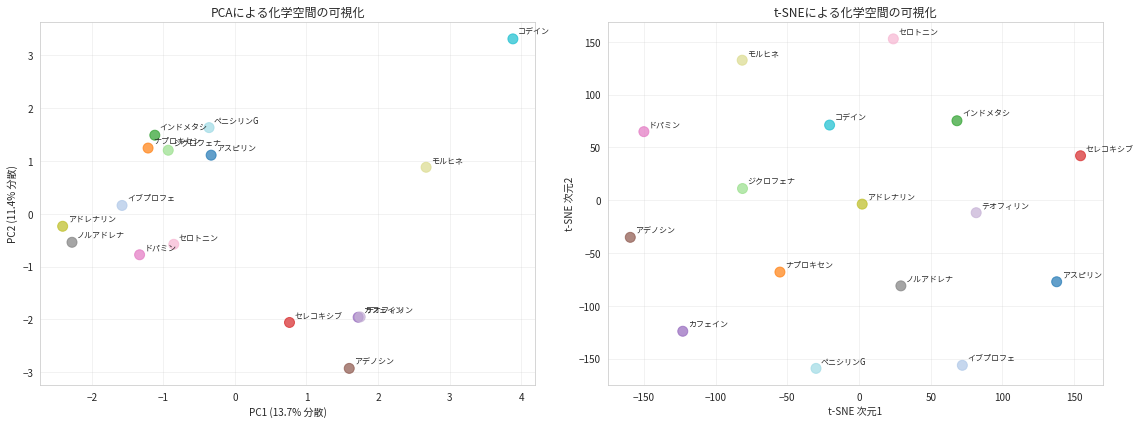

PCA: 第1・第2主成分で 25.1% の分散を説明


In [5]:
# 化学空間の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"

# より多くの分子データを追加
extended_molecules = {
    **test_molecules,
    "カフェイン": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "テオフィリン": "CN1C2=C(C(=O)N(C1=O)C)N=CN2",
    "アデノシン": "C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O",
    "ドパミン": "C1=CC(=C(C=C1CCN)O)O",
    "セロトニン": "C1=CC2=C(C=C1O)C(=CN2)CCN",
    "ノルアドレナリン": "C1=CC(=C(C=C1CC(C(=O)O)N)O)O",
    "アドレナリン": "CNC(CC1=CC(=C(C=C1)O)O)C(=O)O",
    "モルヒネ": "CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O",
    "コデイン": "COC1=C2C3=C(CCN(C3)C)C4=C2C(=CC=C4)OC1C=C",
    "ペニシリンG": "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"
}

# 全分子のフィンガープリントを生成
all_fp_data = {}
valid_molecules = {}

for name, smiles in extended_molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fps = generate_fingerprints(mol)
        all_fp_data[name] = fps
        valid_molecules[name] = smiles

print(f"分析対象分子数: {len(valid_molecules)}")

# Morgan フィンガープリント（r=2）を用いて特徴量行列を作成
mol_names = list(all_fp_data.keys())
n_mols = len(mol_names)

# ビットベクトルを配列に変換
fp_matrix = np.zeros((n_mols, 1024))
for i, mol_name in enumerate(mol_names):
    fp = all_fp_data[mol_name]['Morgan_r2']
    fp_array = np.zeros(1024)
    DataStructs.ConvertToNumpyArray(fp, fp_array)
    fp_matrix[i, :] = fp_array

# PCAによる次元削減
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(fp_matrix)

# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, n_mols-1))
tsne_coords = tsne.fit_transform(fp_matrix)

# 可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PCA プロット
scatter1 = ax1.scatter(pca_coords[:, 0], pca_coords[:, 1], 
                      c=range(n_mols), cmap='tab20', alpha=0.7, s=100)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} 分散)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} 分散)')
ax1.set_title('PCAによる化学空間の可視化')
ax1.grid(True, alpha=0.3)

# 分子名をラベルとして表示
for i, mol_name in enumerate(mol_names):
    ax1.annotate(mol_name[:6], (pca_coords[i, 0], pca_coords[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# t-SNE プロット
scatter2 = ax2.scatter(tsne_coords[:, 0], tsne_coords[:, 1], 
                      c=range(n_mols), cmap='tab20', alpha=0.7, s=100)
ax2.set_xlabel('t-SNE 次元1')
ax2.set_ylabel('t-SNE 次元2')
ax2.set_title('t-SNEによる化学空間の可視化')
ax2.grid(True, alpha=0.3)

# 分子名をラベルとして表示
for i, mol_name in enumerate(mol_names):
    ax2.annotate(mol_name[:6], (tsne_coords[i, 0], tsne_coords[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print(f"PCA: 第1・第2主成分で {pca.explained_variance_ratio_[:2].sum():.1%} の分散を説明")

## 5. クラスタリング分析

分子の構造的類似性に基づいてクラスタリングを行い、化学的に関連する分子群を特定します。

Butinaクラスタリング結果:
クラスタ 1: 2 分子
  - ペニシリンG, セレコキシブ

クラスタ 2: 1 分子
  - コデイン

クラスタ 3: 1 分子
  - モルヒネ

クラスタ 4: 1 分子
  - アドレナリン

クラスタ 5: 1 分子
  - ノルアドレナリン

クラスタ 6: 1 分子
  - セロトニン

クラスタ 7: 1 分子
  - ドパミン

クラスタ 8: 1 分子
  - アデノシン

クラスタ 9: 1 分子
  - テオフィリン

クラスタ 10: 1 分子
  - カフェイン

クラスタ 11: 1 分子
  - ジクロフェナク

クラスタ 12: 1 分子
  - インドメタシン

クラスタ 13: 1 分子
  - ナプロキセン

クラスタ 14: 1 分子
  - イブプロフェン

クラスタ 15: 1 分子
  - アスピリン

最適なクラスタ数 (K-means): 5 (シルエット係数: 0.092)


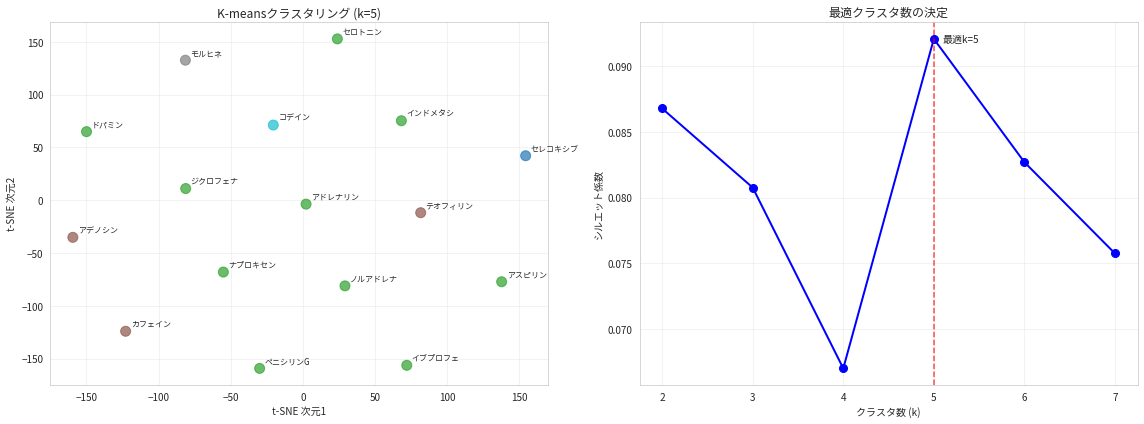

In [6]:
# Butina クラスタリング（RDKitの標準的なクラスタリング手法）
plt.rcParams['font.family'] = "Noto Sans CJK JP"

def butina_clustering(fps, threshold=0.6):
    """Butinaアルゴリズムによるクラスタリング"""
    # 距離行列の計算（1 - Tanimoto類似度）
    distances = []
    n_fps = len(fps)
    
    for i in range(n_fps):
        for j in range(i + 1, n_fps):
            distance = 1.0 - TanimotoSimilarity(fps[i], fps[j])
            distances.append(distance)
    
    # Butinaクラスタリングの実行
    clusters = Butina.ClusterData(distances, n_fps, threshold, isDistData=True)
    return clusters

# フィンガープリントリストの作成
fps_list = [all_fp_data[mol]['Morgan_r2'] for mol in mol_names]

# クラスタリングの実行
clusters = butina_clustering(fps_list, threshold=0.5)

print("Butinaクラスタリング結果:")
print("=" * 40)
for i, cluster in enumerate(clusters):
    print(f"クラスタ {i+1}: {len(cluster)} 分子")
    cluster_mols = [mol_names[idx] for idx in cluster]
    print(f"  - {', '.join(cluster_mols)}")
    print()

# K-meansクラスタリングとの比較
k_values = range(2, min(8, n_mols))
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(fp_matrix)
    score = silhouette_score(fp_matrix, cluster_labels)
    silhouette_scores.append(score)

# 最適なクラスタ数の決定
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"最適なクラスタ数 (K-means): {optimal_k} (シルエット係数: {max(silhouette_scores):.3f})")

# 最適なK-meansクラスタリングの実行
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(fp_matrix)

# クラスタリング結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# t-SNE座標上でのクラスタ表示
scatter1 = axes[0].scatter(tsne_coords[:, 0], tsne_coords[:, 1], 
                          c=kmeans_labels, cmap='tab10', alpha=0.7, s=100)
axes[0].set_xlabel('t-SNE 次元1')
axes[0].set_ylabel('t-SNE 次元2')
axes[0].set_title(f'K-meansクラスタリング (k={optimal_k})')
axes[0].grid(True, alpha=0.3)

for i, mol_name in enumerate(mol_names):
    axes[0].annotate(mol_name[:6], (tsne_coords[i, 0], tsne_coords[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

# シルエット係数の変化
axes[1].plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[1].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('クラスタ数 (k)')
axes[1].set_ylabel('シルエット係数')
axes[1].set_title('最適クラスタ数の決定')
axes[1].grid(True, alpha=0.3)
axes[1].text(optimal_k + 0.1, max(silhouette_scores), f'最適k={optimal_k}', 
            fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

## 6. バーチャルスクリーニングの実装

実際の創薬研究で用いられるバーチャルスクリーニングを実装します。既知の活性化合物に類似した化合物を大規模ライブラリから検索します。

In [7]:
# バーチャルスクリーニングの実装
class VirtualScreening:
    def __init__(self, reference_mols, fp_type='Morgan_r2'):
        """
        バーチャルスクリーニングクラス
        
        Parameters:
        reference_mols: 基準となる活性化合物のSMILESリスト
        fp_type: 使用するフィンガープリントの種類
        """
        self.reference_mols = reference_mols
        self.fp_type = fp_type
        self.reference_fps = []
        
        # 基準分子のフィンガープリントを生成
        for smiles in reference_mols:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fps = generate_fingerprints(mol)
                if fp_type in fps:
                    self.reference_fps.append(fps[fp_type])
    
    def screen_compound(self, compound_smiles, similarity_threshold=0.6):
        """
        化合物のスクリーニング
        
        Parameters:
        compound_smiles: テスト化合物のSMILES
        similarity_threshold: 類似性の閾値
        
        Returns:
        dict: スクリーニング結果
        """
        mol = Chem.MolFromSmiles(compound_smiles)
        if mol is None:
            return None
        
        fps = generate_fingerprints(mol)
        if self.fp_type not in fps:
            return None
        
        compound_fp = fps[self.fp_type]
        
        # 各基準分子との類似性を計算
        similarities = []
        for ref_fp in self.reference_fps:
            sim = TanimotoSimilarity(compound_fp, ref_fp)
            similarities.append(sim)
        
        max_similarity = max(similarities) if similarities else 0
        mean_similarity = np.mean(similarities) if similarities else 0
        
        result = {
            'SMILES': compound_smiles,
            'max_similarity': max_similarity,
            'mean_similarity': mean_similarity,
            'is_hit': max_similarity >= similarity_threshold,
            'similarities': similarities
        }
        
        return result
    
    def screen_library(self, library_smiles, similarity_threshold=0.6):
        """
        化合物ライブラリのスクリーニング
        
        Parameters:
        library_smiles: 化合物ライブラリのSMILESリスト
        similarity_threshold: 類似性の閾値
        
        Returns:
        list: スクリーニング結果のリスト
        """
        results = []
        for smiles in library_smiles:
            result = self.screen_compound(smiles, similarity_threshold)
            if result is not None:
                results.append(result)
        
        return results

# NSAIDs（非ステロイド系抗炎症薬）を基準分子として設定
reference_nsaids = [
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # アスピリン
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
    "COC1=CC=CC2=C1C=C(C=C2)C(C)C(=O)O"  # ナプロキセン
]

# テスト用化合物ライブラリ
test_library = [
    "O=C(O)CC1=CC=CC=C1NC2=C(Cl)C=CC=C2Cl",  # ジクロフェナク（NSAID）
    "CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O",  # インドメタシン（NSAID）
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # カフェイン（非NSAID）
    "C1=CC(=C(C=C1CCN)O)O",  # ドパミン（非NSAID）
    "CC(CC1=CC=CC=C1)C(=O)O",  # フェニルプロピオン酸（NSAID様）
    "COC1=CC=C(C=C1)C(=O)C2=CC=CC=C2",  # 4-メトキシベンゾフェノン（非NSAID）
    "CC1=CC=C(C=C1)S(=O)(=O)NC2=NC(=CS2)C",  # スルファメトキサゾール（抗生物質）
    "NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=CC=C2"  # スルファニルアミド（抗生物質）
]

# バーチャルスクリーニングの実行
vs = VirtualScreening(reference_nsaids, fp_type='Morgan_r2')
screening_results = vs.screen_library(test_library, similarity_threshold=0.4)

print("バーチャルスクリーニング結果:")
print("=" * 60)
print(f"基準分子数: {len(reference_nsaids)}")
print(f"スクリーニング化合物数: {len(test_library)}")
print(f"有効結果数: {len(screening_results)}")
print()

# 結果をDataFrameに変換
df_screening = pd.DataFrame([
    {
        'SMILES': result['SMILES'],
        '最大類似度': result['max_similarity'],
        '平均類似度': result['mean_similarity'],
        'ヒット判定': result['is_hit']
    }
    for result in screening_results
])

# 類似度順にソート
df_screening = df_screening.sort_values('最大類似度', ascending=False)
print("スクリーニング結果（類似度順）:")
print(df_screening.round(3))

バーチャルスクリーニング結果:
基準分子数: 3
スクリーニング化合物数: 8
有効結果数: 8

スクリーニング結果（類似度順）:
                                            SMILES  最大類似度  平均類似度  ヒット判定
4                           CC(CC1=CC=CC=C1)C(=O)O  0.516  0.376   True
5                  COC1=CC=C(C=C1)C(=O)C2=CC=CC=C2  0.343  0.279  False
0             O=C(O)CC1=CC=CC=C1NC2=C(Cl)C=CC=C2Cl  0.205  0.189  False
1  CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O  0.189  0.177  False
3                             C1=CC(=C(C=C1CCN)O)O  0.179  0.133  False
7              NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=CC=C2  0.167  0.130  False
6             CC1=CC=C(C=C1)S(=O)(=O)NC2=NC(=CS2)C  0.121  0.114  False
2                     CN1C=NC2=C1C(=O)N(C(=O)N2C)C  0.114  0.100  False


[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:47] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:47] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:47] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use AtomPairGenerator
[17:00:47] DEPRECATION WARNING: please use TopologicalTorsionGenerator


## 7. スクリーニング結果の可視化と分析

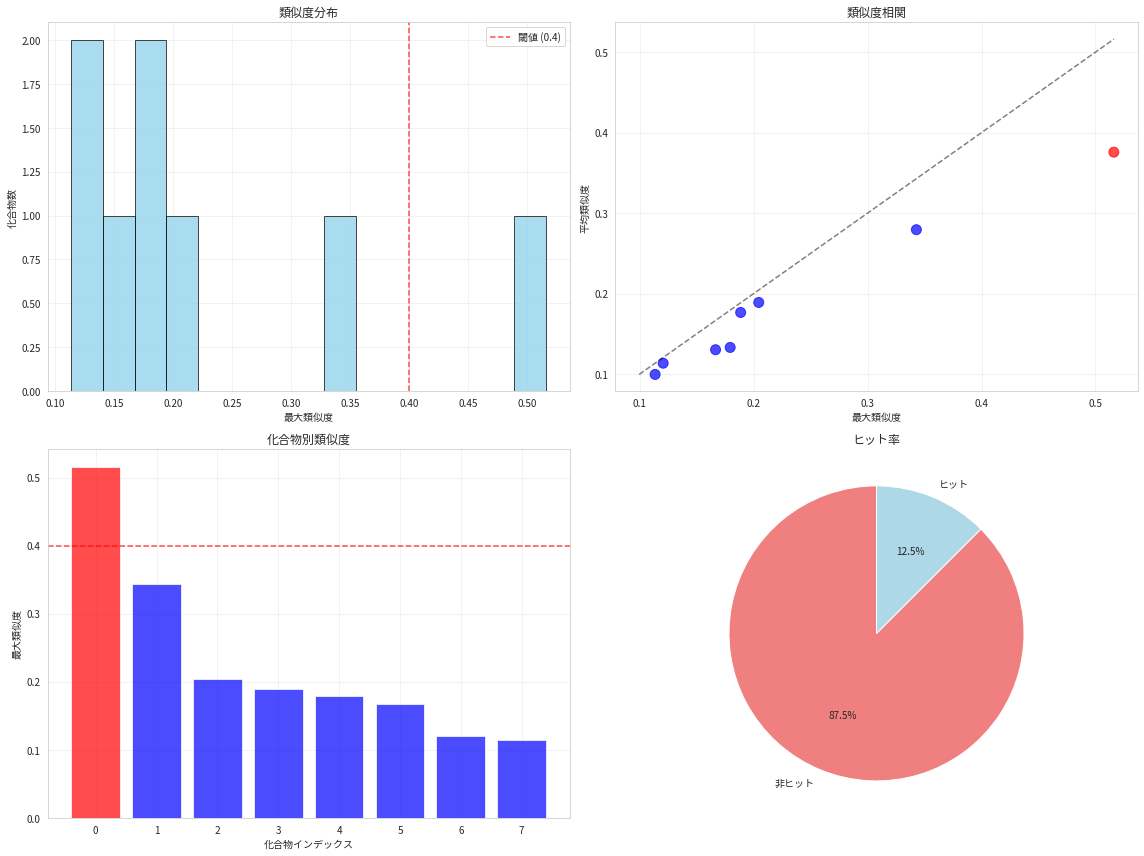


スクリーニング統計:
総化合物数: 8
ヒット数: 1
ヒット率: 12.5%
最大類似度 - 平均: 0.229 ± 0.136
平均類似度 - 平均: 0.187 ± 0.095


In [8]:
# スクリーニング結果の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 類似度分布のヒストグラム
axes[0, 0].hist(df_screening['最大類似度'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=0.4, color='red', linestyle='--', alpha=0.7, label='閾値 (0.4)')
axes[0, 0].set_xlabel('最大類似度')
axes[0, 0].set_ylabel('化合物数')
axes[0, 0].set_title('類似度分布')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 最大類似度 vs 平均類似度の散布図
colors = ['red' if hit else 'blue' for hit in df_screening['ヒット判定']]
axes[0, 1].scatter(df_screening['最大類似度'], df_screening['平均類似度'], 
                  c=colors, alpha=0.7, s=100)
axes[0, 1].set_xlabel('最大類似度')
axes[0, 1].set_ylabel('平均類似度')
axes[0, 1].set_title('類似度相関')
axes[0, 1].grid(True, alpha=0.3)

# 対角線を描画
min_val = min(df_screening['最大類似度'].min(), df_screening['平均類似度'].min())
max_val = max(df_screening['最大類似度'].max(), df_screening['平均類似度'].max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# 3. 化合物別類似度バープロット
compound_indices = range(len(df_screening))
axes[1, 0].bar(compound_indices, df_screening['最大類似度'], 
              color=['red' if hit else 'blue' for hit in df_screening['ヒット判定']], 
              alpha=0.7)
axes[1, 0].axhline(y=0.4, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('化合物インデックス')
axes[1, 0].set_ylabel('最大類似度')
axes[1, 0].set_title('化合物別類似度')
axes[1, 0].grid(True, alpha=0.3)

# 4. ヒット/非ヒットの集計
hit_counts = df_screening['ヒット判定'].value_counts()
axes[1, 1].pie(hit_counts.values, labels=['非ヒット' if not x else 'ヒット' for x in hit_counts.index], 
              autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
axes[1, 1].set_title('ヒット率')

plt.tight_layout()
plt.show()

# 統計情報の表示
print("\nスクリーニング統計:")
print("=" * 30)
print(f"総化合物数: {len(df_screening)}")
print(f"ヒット数: {df_screening['ヒット判定'].sum()}")
print(f"ヒット率: {df_screening['ヒット判定'].mean():.1%}")
print(f"最大類似度 - 平均: {df_screening['最大類似度'].mean():.3f} ± {df_screening['最大類似度'].std():.3f}")
print(f"平均類似度 - 平均: {df_screening['平均類似度'].mean():.3f} ± {df_screening['平均類似度'].std():.3f}")

## 8. 多様性を考慮した化合物選択

創薬研究では類似性だけでなく、化合物の多様性も重要です。MaxMinアルゴリズムを用いて多様性を考慮した化合物選択を行います。

多様性を考慮した化合物選択:
ライブラリサイズ: 15
選択された 5 化合物:
1. 化合物_1: CC(=O)OC1=CC=CC=C1C(=O)O
2. 化合物_10: C1=CC2=C(C=C1O)C(=CN2)CCN
3. 化合物_8: CN1C=NC2=C1C(=O)N(C(=O)N2C)C
4. 化合物_6: CC1=CC=C(C=C1)S(=O)(=O)NC2=NC(=CS2)C
5. 化合物_5: CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O


[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerator
[17:00:47] DEPRECATION WARNING: please use MorganGenerat

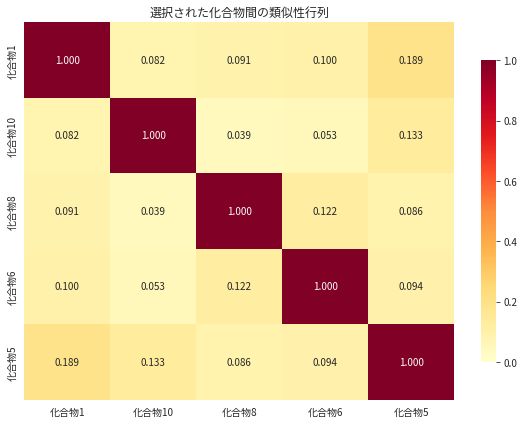


多様性統計:
化合物間平均類似度: 0.099 ± 0.040
最小類似度: 0.039
最大類似度: 0.189


In [9]:
# MaxMinアルゴリズムによる多様性を考慮した化合物選択
def maxmin_picker(compounds, n_picks, similarity_threshold=0.7):
    """
    MaxMinアルゴリズムによる多様な化合物の選択
    
    Parameters:
    compounds: 化合物のSMILESリスト
    n_picks: 選択する化合物数
    similarity_threshold: 類似性の閾値
    
    Returns:
    list: 選択された化合物のインデックス
    """
    if n_picks >= len(compounds):
        return list(range(len(compounds)))
    
    # 分子とフィンガープリントの生成
    mols = []
    fps = []
    for smiles in compounds:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            mols.append(mol)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fps.append(fp)
    
    if len(fps) < n_picks:
        return list(range(len(fps)))
    
    # 最初の化合物をランダムに選択
    picked = [0]
    
    # 残りの化合物を順次選択
    for _ in range(n_picks - 1):
        max_min_distance = -1
        best_candidate = -1
        
        for i, fp in enumerate(fps):
            if i in picked:
                continue
            
            # 既に選択された化合物との最小距離を計算
            min_distance = float('inf')
            for j in picked:
                similarity = TanimotoSimilarity(fp, fps[j])
                distance = 1.0 - similarity
                min_distance = min(min_distance, distance)
            
            # 最小距離が最大の候補を選択
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                best_candidate = i
        
        if best_candidate != -1:
            picked.append(best_candidate)
    
    return picked

# より大きな化合物ライブラリを作成
extended_library = [
    # NSAIDs
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # アスピリン
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
    "COC1=CC=CC2=C1C=C(C=C2)C(C)C(=O)O",  # ナプロキセン
    "O=C(O)CC1=CC=CC=C1NC2=C(Cl)C=CC=C2Cl",  # ジクロフェナク
    "CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O",  # インドメタシン
    
    # 抗生物質
    "CC1=CC=C(C=C1)S(=O)(=O)NC2=NC(=CS2)C",  # スルファメトキサゾール
    "NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=CC=C2",  # スルファニルアミド
    
    # 神経系薬物
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # カフェイン
    "C1=CC(=C(C=C1CCN)O)O",  # ドパミン
    "C1=CC2=C(C=C1O)C(=CN2)CCN",  # セロトニン
    
    # その他の化合物
    "COC1=CC=C(C=C1)C(=O)C2=CC=CC=C2",  # 4-メトキシベンゾフェノン
    "CC(CC1=CC=CC=C1)C(=O)O",  # フェニルプロピオン酸
    "C1=CC=C(C=C1)C(=O)O",  # 安息香酸
    "CC1=CC=CC=C1C(=O)O",  # o-トルイル酸
    "C1=CC=C(C=C1)O"  # フェノール
]

print("多様性を考慮した化合物選択:")
print("=" * 40)
print(f"ライブラリサイズ: {len(extended_library)}")

# 5つの多様な化合物を選択
n_diverse = 5
diverse_indices = maxmin_picker(extended_library, n_diverse)

print(f"選択された {n_diverse} 化合物:")
for i, idx in enumerate(diverse_indices):
    mol = Chem.MolFromSmiles(extended_library[idx])
    mol_name = f"化合物_{idx+1}"
    print(f"{i+1}. {mol_name}: {extended_library[idx]}")

# 選択された化合物間の類似性を確認
selected_fps = []
for idx in diverse_indices:
    mol = Chem.MolFromSmiles(extended_library[idx])
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        selected_fps.append(fp)

# 類似性行列の計算
n_selected = len(selected_fps)
diversity_matrix = np.zeros((n_selected, n_selected))

for i in range(n_selected):
    for j in range(n_selected):
        similarity = TanimotoSimilarity(selected_fps[i], selected_fps[j])
        diversity_matrix[i, j] = similarity

# 多様性の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
plt.figure(figsize=(8, 6))

sns.heatmap(diversity_matrix, 
            annot=True, 
            fmt='.3f',
            xticklabels=[f'化合物{diverse_indices[i]+1}' for i in range(n_selected)],
            yticklabels=[f'化合物{diverse_indices[i]+1}' for i in range(n_selected)],
            cmap='YlOrRd',
            vmin=0, vmax=1,
            cbar_kws={'shrink': 0.8})

plt.title('選択された化合物間の類似性行列')
plt.tight_layout()
plt.show()

# 多様性統計
off_diagonal = diversity_matrix[np.triu_indices_from(diversity_matrix, k=1)]
print(f"\n多様性統計:")
print(f"化合物間平均類似度: {off_diagonal.mean():.3f} ± {off_diagonal.std():.3f}")
print(f"最小類似度: {off_diagonal.min():.3f}")
print(f"最大類似度: {off_diagonal.max():.3f}")

## まとめ

本ノートブックでは、分子類似性検索の様々な手法について学習しました：

### 主要なポイント

1. **フィンガープリント手法**:
   - Morgan (ECFP)、RDKit、MACCS、AtomPair、TopologicalTorsion
   - 用途に応じた適切な手法の選択が重要

2. **類似性指標**:
   - Tanimoto係数：最も一般的で対称的
   - Dice係数：Tanimoto係数より高い値を示す傾向
   - Tversky係数：非対称的な類似性評価が可能

3. **化学空間の可視化**:
   - PCA：線形次元削減、解釈しやすい
   - t-SNE：非線形次元削減、クラスタ構造を保持

4. **クラスタリング**:
   - Butinaクラスタリング：化学的に意味のあるクラスタ
   - K-meansクラスタリング：効率的だが球状クラスタを仮定

5. **バーチャルスクリーニング**:
   - 既知活性化合物からの類似化合物探索
   - 閾値設定とヒット率の最適化

6. **多様性選択**:
   - MaxMinアルゴリズム：多様性を考慮した化合物選択
   - 類似性と多様性のバランス

### 創薬への応用

- **リード化合物最適化**: 構造活性相関の理解
- **化合物ライブラリ設計**: 多様性を考慮した合成標的選択
- **薬物再配置**: 既存薬物の新たな適応症探索
- **副作用予測**: 類似化合物の既知副作用からの推定

### 次のステップ

1. 活性データを用いた教師ありモデル構築
2. 3D分子構造を考慮した類似性評価
3. 機械学習による類似性指標の学習
4. 大規模データベースでの高速検索アルゴリズム

In [10]:
# 最終統計情報
plt.rcParams['font.family'] = "Noto Sans CJK JP"

print("分子類似性検索学習の統計情報:")
print("=" * 50)
print(f"解析フィンガープリント種類: {len(fingerprint_types)}")
print(f"解析分子数: {len(valid_molecules)}")
print(f"バーチャルスクリーニング対象: {len(test_library)}")
print(f"多様性選択ライブラリ: {len(extended_library)}")
print(f"最終選択化合物数: {len(diverse_indices)}")

print("\n各手法の特徴:")
print("-" * 30)
print("• Morgan フィンガープリント: 環境情報を考慮、半径可変")
print("• MACCS キー: 166の構造パターン、高速")
print("• RDKit フィンガープリント: パス情報、構造多様性")
print("• Tanimoto係数: 対称的、一般的")
print("• バーチャルスクリーニング: 効率的な候補化合物探索")
print("• 多様性選択: MaxMinアルゴリズム、探索空間最大化")

print("\n学習が完了しました！")

分子類似性検索学習の統計情報:
解析フィンガープリント種類: 6
解析分子数: 16
バーチャルスクリーニング対象: 8
多様性選択ライブラリ: 15
最終選択化合物数: 5

各手法の特徴:
------------------------------
• Morgan フィンガープリント: 環境情報を考慮、半径可変
• MACCS キー: 166の構造パターン、高速
• RDKit フィンガープリント: パス情報、構造多様性
• Tanimoto係数: 対称的、一般的
• バーチャルスクリーニング: 効率的な候補化合物探索
• 多様性選択: MaxMinアルゴリズム、探索空間最大化

学習が完了しました！


## 補助資料

### ダウンロード

- <a class="link" href="/files/similarity_search_executed.ipynb" download>実行済みJupyter Notebook (.ipynb)</a>